In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/ML_Project_RL/images'

/content/gdrive/MyDrive/ML_Project_RL/images


In [3]:
import pandas as pd
import os
import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from skimage import io, transform
from skimage.color import gray2rgb
from PIL import Image, ImageEnhance
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
import copy
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [4]:
#Preparing the dataset
curr_path = os.getcwd()
train_path = os.path.join(curr_path, 'train')
test_path = os.path.join(curr_path, 'test')
class_map = {'happy': 0, 'neutral':1, 'angry': 2, 'fearful': 3, 'surprised': 4, 'disgusted': 5, 'sad': 6}

In [5]:
def prepare_dataset(datapath):
  list_of_classes = os.listdir(datapath)
  labels = []
  image_paths = []
  for idx, img_class in enumerate(list_of_classes):
    path = os.path.join(datapath, img_class)
    images =os.listdir(path)
    for img in images:
      image_paths.append(os.path.join(path, img))
      labels.append(class_map[img_class])
  
  return image_paths, labels

In [6]:
train_img_paths, train_labels = prepare_dataset(train_path)
test_img_paths, test_labels = prepare_dataset(test_path)

In [7]:
class_weights = []
total_size = len(train_labels)
_,counts = np.unique(np.array(train_labels), return_counts=True)
for count in counts:
  class_weights.append((count/total_size))

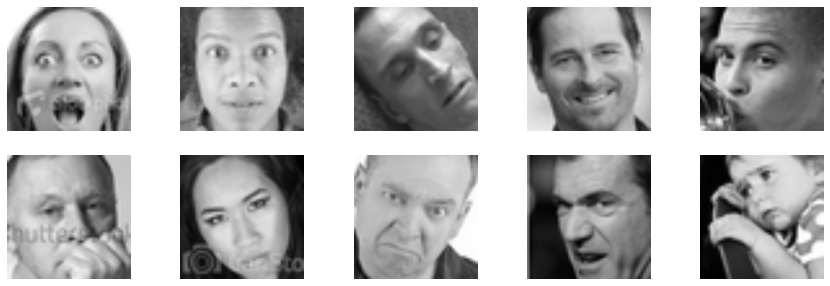

In [8]:
plt.figure(figsize = (15,5))
for i in range(10):
  index = random.randint(0, len(train_img_paths)-1)
  im = cv2.imread(train_img_paths[index])
  im_resized = cv2.resize(im, (256, 256))
  plt.subplot(2,5,i+1)
  plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
  plt.axis('off')

plt.show()

In [9]:
class EmotionDataset(Dataset):

    def __init__(self, data_labels, dataset, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.data_labels = data_labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]               
        image = Image.open(img_name)
        #image = gray2rgb(image)
        enhancer = ImageEnhance.Sharpness(image)
        image_s = enhancer.enhance(2)
        
        type_p = self.data_labels[idx]
        if self.transform:
            image_s = self.transform(image_s)

        return image_s, type_p

In [18]:
transform_normal = transforms.Compose([                                      
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    
])
transform_rotate = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((256,256)),                              
    transforms.CenterCrop(240),
    transforms.Resize((224,224)), 
    transforms.RandomRotation(degrees = 45),
    transforms.ToTensor()
    
])

transform_flip = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((256,256)),                              
    transforms.CenterCrop(240),
    transforms.Resize((224,224)), 
    transforms.ToTensor()
    
])
transform_jitter = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0),
    transforms.Resize((256,256)),                              
    transforms.CenterCrop(240),
    transforms.Resize((224,224)), 
    transforms.ToTensor()
    
])

In [11]:
train_datasets = []
train_datasets.append(EmotionDataset( train_labels, train_img_paths, transform=transform_normal))
train_ds = torch.utils.data.ConcatDataset(train_datasets)
train_dl = DataLoader(train_ds, batch_size=1,shuffle=True)

In [12]:
test_datasets = []
test_datasets.append(EmotionDataset( test_labels, test_img_paths, transform=transform_normal))
test_ds = torch.utils.data.ConcatDataset(test_datasets)
test_dl = DataLoader(test_ds, batch_size=1,shuffle=True)

tensor([0])
tensor([1])


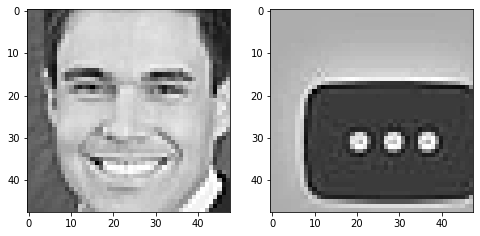

In [23]:
#Normalized images after applying transormations
fig = plt.figure(figsize=(8,8))
count = 0
for xb,yb in test_dl :
      img = xb.squeeze()
      #img = img.permute(1,2,0)
      ax1 = fig.add_subplot(1,2, count+1)
      ax1.imshow(img, cmap='gray')
      print(yb)
      count+=1
      if count>=2:
        break

In [ ]:
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [ ]:
model = models.resnet34(pretrained=True)
model.conv1 = nn.Conv2d(1,64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
newmodel.to(device)

In [ ]:
# Hooks to extract the intermediate feature maps
newmodel[5].register_forward_hook(get_activation('layer2'))
newmodel[6].register_forward_hook(get_activation('layer3'))

##### Reduce the dimensions of the intermediate representations using CONV 1X1 kernel and max pooling. Max pooling is choosen over average pooling as max pooling extract the features that have max values and present in an image. 

In [ ]:

network1 = nn.Sequential(
    nn.Conv2d(in_channels=128, kernel_size=(1,1), out_channels=512),
    nn.AdaptiveMaxPool2d(output_size=(1, 1)))
network2 = nn.Sequential(
    nn.Conv2d(in_channels=256, kernel_size=(1,1), out_channels=512),
    nn.AdaptiveMaxPool2d(output_size=(1, 1)))

In [ ]:
def feature_extractor(dataset,model, layer=None):
  features = []
  labels = []
  model.eval()
  in_map_arr = np.array([])
  tk0 = tqdm(dataset)
  for idx , (data , label ) in enumerate(tk0):
    data , label = data.to(device) , label.to(device)
    outputs = model(data)
    if layer is not None:
      in_map = activation[layer]
    if layer == 'layer2':
      in_map = network1(in_map)
      in_map_arr = torch.flatten(in_map).cpu().detach().numpy()
    if layer == 'layer3':
      in_map = network2(in_map)
      in_map_arr = torch.flatten(in_map).cpu().detach().numpy()
   
    outputs = torch.flatten(outputs)
    outputs_arr = outputs.cpu().detach().numpy()
    final_arr = np.concatenate((outputs_arr, in_map_arr))
    features.append(final_arr)
    labels.append(label)
   
  labels = np.array(labels)
  return [features, labels]

In [ ]:
train_features_1 = feature_extractor(train_dl, model, layer='layer2')
test_features_1 = feature_extractor(test_dl, model, layer='layer2')

100%|██████████| 7178/7178 [24:19<00:00,  4.92it/s]


In [ ]:
train_features_2 = feature_extractor(train_dl,model, layer='layer3')
test_features_2 = feature_extractor(test_dl,model, layer='layer3')

In [ ]:
train_features_3 = feature_extractor(train_dl, model,layer=None)
test_features_3 = feature_extractor(test_dl, model,layer=None)   

100%|██████████| 7178/7178 [47:00<00:00,  2.54it/s]


In [ ]:
#Voting/Stacking
  #Voting
  SVC_clf_1 = OneVsOneClassifier(SVC(kernel='linear', class_weight='balanced'))
  SVC_clf_2 =  OneVsRestClassifier(SVC(kernel='rbf', C=1, class_weight='balanced'))
  SVC_clf_3 = SVC(kernel='poly' , C=1)
  voting_clf = VotingClassifier(estimators=[('SVC_1', SVC_clf_1), ('SVC_2', SVC_clf_2), ('SVC_3', SVC_clf_3)], voting='hard')
  voting_clf.fit(train_features[0], train_features[1])
  test_pred_1 = voting_clf.predict(test_features[0])
  print('Precision score for Voting: ', precision_score(test_features[1], test_pred_1  average='weighted'))
  print('F1 score for Voting: ', f1_score(test_pred_1, test_features[1], test_pred_1  average='weighted'))
  print('Accuracy score for Voting: ', accuracy_score( test_features[1], test_pred_1))
  

In [ ]:
#Boosting
model_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50,100,150,200,250]
             }


decision_tree = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = 3)
boosting_clf_ada_boost = AdaBoostClassifier(base_estimator = decision_tree)


clf = RandomizedSearchCV(boosting_clf_ada_boost, model_params, n_iter=100, cv=5, random_state=1)
clf.fit(train_features_1[0], train_features_1[1])
test_pred_2 = clf.predict(test_features_1[0])
print('Precision score for Boosting: ', precision_score(test_pred_2, test_features_1[1],  average='weighted'))
print('F1 score for Boosting: ', f1_score(test_pred_2, test_features_1[1],  average='weighted'))
print('Accuracy score for Boosting: ', accuracy_score(test_pred_2, test_features_1[1]))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Precision score for Boosting:  0.3024995790047237
F1 score for Boosting:  0.2956692377862301
Accuracy score for Boosting:  0.296600724435776


In [ ]:
 #Bagging
model_params = {
 'max_depth': [1.3,5,None],
 'n_estimators': [50, 150, 200]}

rf = RandomForestClassifier()
bagging_clf_rf = RandomizedSearchCV(rf, model_params, n_iter=100, cv=5, random_state=42)
bagging_clf_rf.fit(train_features_3[0], train_features_3[1])
test_pred_3 = bagging_clf_rf.predict(test_features_3[0])
print('Precision score for Bagging: ', precision_score( test_features_3[1], test_pred_3,  average='weighted'))
print('F1 score for Bagging: ', f1_score(test_features_3[1], test_pred_3,  average='weighted'))
print('Accuracy score for Bagging: ', accuracy_score(test_features_3[1], test_pred_3))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Precision score for Bagging:  0.4660452671266108
F1 score for Bagging:  0.41536032371909
Accuracy score for Bagging:  0.4310392867093898


Plotting the accuracies of three models

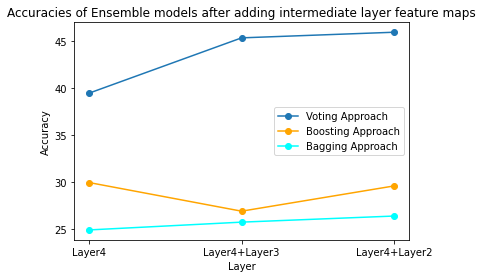

In [ ]:
voting_acc = [39.48, 45.37, 45.97]
boosting_acc = [29.92, 26.87, 29.56]
bagging_acc = [24.87, 25.70, 26.35]
x_data = ["Layer4", "Layer4+Layer3", "Layer4+Layer2"]
plt.title("Accuracies of Ensemble models after adding intermediate layer feature maps")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.plot(x_data, voting_acc, label="Voting Approach", marker='o')
plt.plot(x_data, boosting_acc, color='orange', label="Boosting Approach", marker='o')
plt.plot(x_data, bagging_acc, color='cyan', label="Bagging Approach", marker='o')
plt.legend()
plt.show()